# Tidal Project

import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import tensorflow as tf

download and open the data

In [2]:
#define the filename
fname = 'Downloads/ASTR19_S22_group_project_data.txt'

#open the file with numpy loadtxt
test_data = np.loadtxt(fname, dtype={'names': ('day', 'time', 'height'),'formats': ('i4', 'S5', 'f4')})

#print the info from the file
#print(test_data)

plt.style.use("Downloads/astr19_matplotlib_defaults.txt")

In [ ]:
#create a figure
fig = plt.figure(figsize=(10,5))
ax = plt.subplot
plt.xlabel('Time (days)')
plt.ylabel('Height of wave (ft)')

#create empty lists for x and y variables
result_x = []
result_y = []

#converting data & putting into the lists
for item in test_data:
    day = item [0]
    time = item [1].decode()
    height = item [2]
    Day = (day)
    TimeParts = time.split(":")
    daysfromhour = int(TimeParts[0])/24
    daysfromminutes = int(TimeParts[1])/60/24
    timeindays = day + daysfromhour + daysfromminutes
    x = timeindays
    y = height
    result_x.append(x)
    result_y.append(y)
    plt.scatter(x,y)

#converting result lists into arrays
result_x = np.asarray(result_x)
result_y = np.asarray(result_y)


#fitting a curve to the data

#define the function to fit
def f_line(x, a, b, c, d):
    return a * np.sin(b*x + c) + d

#perform the fit
params, params_cov = optimize.curve_fit(f_line, result_x, result_y, p0=[3, 0.5, 1, 2])

a_fit = params[0]
b_fit = params[1]
c_fit = params[2]
d_fit = params[3]

y_fit = a_fit * np.sin(b_fit*result_x + c_fit) + d_fit


#plot the fit on the figure
plt.errorbar(result_x, result_y, fmt='o', label='data')
plt.plot(result_x, y_fit, label='fit')
plt.legend(loc=0, frameon=False)
plt.show()     #delete later

#save the figure as a PDF
#plt.savefig('project-figure.pdf', bbox_inches='tight', dpi=600, facecolor='white')

### using tensorflow??

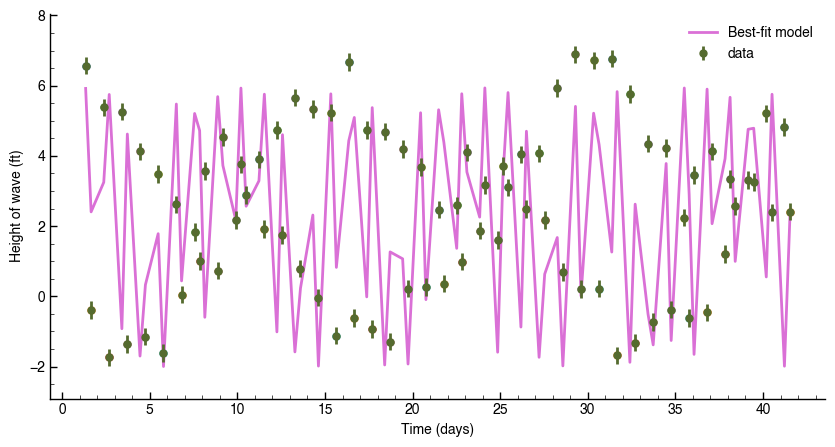

In [62]:
#define the filename
fname = 'Downloads/ASTR19_S22_group_project_data.txt'

#open the file with numpy loadtxt
test_data = np.loadtxt(fname, dtype={'names': ('day', 'time', 'height'),'formats': ('i4', 'S5', 'f4')})

plt.style.use("Downloads/astr19_matplotlib_defaults.txt")
fig = plt.figure(figsize=(10,5))
ax = plt.subplot
plt.xlabel('Time (days)')
plt.ylabel('Height of wave (ft)')


result_x = []
result_y = []
for item in test_data:
    day = item [0]
    time = item [1].decode()
    height = item [2]
    Day = (day)
    TimeParts = time.split(":")
    daysfromhour = int(TimeParts[0])/24
    daysfromminutes = int(TimeParts[1])/60/24
    timeindays = day + daysfromhour + daysfromminutes
    x = timeindays
    y = height
    result_x.append(x)
    result_y.append(y)
    plt.scatter(x,y)


result_x = np.asarray(result_x)
result_y = np.asarray(result_y)



#amplitude
A_init =4.0
A_fit = tf.Variable(A_init, name='amplitude')
#frequency
f_init = 5.0
f_fit = tf.Variable(f_init, name='frequency')
#phase
p_init = 20.0
p_fit = tf.Variable(p_init, name='phase')
#phase shift the entire curve
d_init = 2.0
d_fit = tf.Variable(d_init, name='vertical shift')

#sinusoidal curve
def sinusoid(x, A, f, p, d):
    return A*np.sin(f*x+p)+d

#define the sinusoidal model
@tf.function
def sinusoidal_model(result_x):
    return A_fit * tf.math.sin(f_fit*x + p_fit)+d_fit

#define the loss function
@tf.function
def mse(y_true, y_pred):
    #mse between true and predicted values
    return tf.losses.mean_squared_error(y_true, y_pred)


#Adam optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)


#start training
epochs = 5000     #number of epochs to run
display_step = 1000    #number of epochs between printing info to screen
for epoch in range(epochs):
    if((epoch%display_step)==0):
        pred = sinusoidal_model(result_x)
        loss = mse(pred, result_y)
    with tf.GradientTape() as g:
        pred = sinusoidal_model(result_x)
        loss = mse(result_y, pred)
    gradients = g.gradient(loss, [A_fit, f_fit, p_fit, d_fit])
    optimizer.apply_gradients(zip(gradients, [A_fit, f_fit, p_fit, d_fit]))


x_model = np.sort(result_x)
y_model = sinusoid(x_model, A_fit, f_fit, p_fit, d_fit)


#plotting the best fit
plt.plot(x_model, y_model, color='orchid', label='Best-fit model')
plt.errorbar(result_x, result_y, yerr=0.25, color='darkolivegreen', fmt='o', label='data')
plt.legend(loc=0, frameon=False)

### plotting residuals & histograms :/

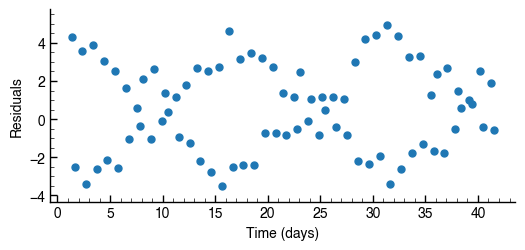

In [67]:
y_fit = a_fit * np.sin(b_fit*result_x + c_fit) + d_fit

residuals = result_y - y_fit

plt.figure()
plt.scatter(result_x, residuals)
plt.xlabel('Time (days)')
plt.ylabel('Residuals')
plt.show()

In [65]:
#Standard Deviation & mean
residuals_std = np.std(residuals)
residuals_mean = np.mean(residuals)

print(f'Standard Deviation of Residuals: {residuals_std:.4f}')
print(f'Mean of Residuals: {residuals_mean:.4f}')

Standard Deviation of Residuals: 2.2704
Mean of Residuals: 0.5705


Text(0, 0.5, 'N per bin')

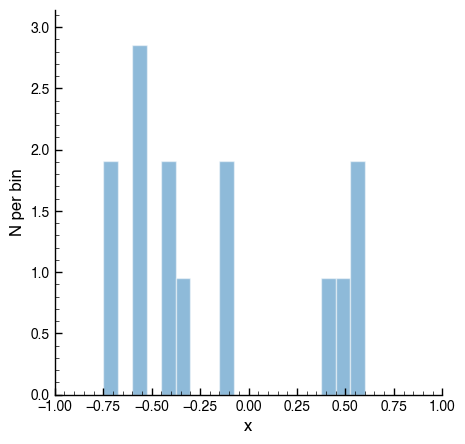

In [66]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
plt.hist(residuals, bins=20, range=(-0.75,0.75), alpha=0.5,edgecolor='white',density=True)

x_g = np.linspace(-5*residuals_std, 5*residuals_std, 1000)
#ax.plot(x_g, gaussian(x_g, residuals_mean, residuals_std), color='red')
ax.set_xlim([-1,1])
#ax.text(0.5, 1.2, r'$\sigma = 0.25$', color='0', fontsize=32)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('N per bin', fontsize=12)
#plt.savefig('gp-histogram.pdf', bbox_inches='tight', dpi=400)